## 0)Common utilities

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

import os, json
import numpy as np
import pandas as pd
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass

from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.utils import check_random_state

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
import optuna


# ---------- Basic helpers ----------
def _rmse(y_true, y_pred) -> float:
    """Root-mean-square error as a float."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def _to_arr(a):
    """Convert pandas objects to numpy arrays; passthrough for numpy inputs."""
    if isinstance(a, (pd.DataFrame, pd.Series)):
        return a.to_numpy()
    return np.asarray(a)

def _gpu_available() -> bool:
    """Heuristic check for a usable GPU."""
    try:
        import torch
        if torch.cuda.is_available(): return True
    except Exception:
        pass
    try:
        import cupy
        if cupy.cuda.runtime.getDeviceCount() > 0: return True
    except Exception:
        pass
    import shutil, os
    if shutil.which("nvidia-smi"): return True
    if os.environ.get("CUDA_VISIBLE_DEVICES", "") not in ("", "-1", None): return True
    return False

GPU_OK = _gpu_available()

def with_device_params(model_name: str, params: dict, prefer_gpu: bool = True) -> dict:
    """
    Normalize device-related params across libraries.
    - xgboost: use device='cuda' (2.x API) + tree_method='hist'
    - lightgbm: device='gpu'
    - catboost: task_type='GPU'
    """
    p = dict(params)
    if not prefer_gpu:
        return p
    if model_name == "xgboost":
        if GPU_OK:
            p["device"] = "cuda"
        p["tree_method"] = "hist"
    elif model_name == "lightgbm":
        if GPU_OK:
            p["device"] = "gpu"
    elif model_name == "catboost":
        if GPU_OK:
            p["task_type"] = "GPU"
            p.setdefault("devices", "0")
    return p


# ---------- Build base models (also maps Torch-MLP-like params to sklearn-MLP) ----------
def build_base_models(best_params: Dict[str, dict], prefer_gpu: bool = True) -> Dict[str, object]:
    """
    Construct model objects from Stage-2 best param JSON.
    Keys expected: 'xgboost', 'lightgbm', 'catboost', 'mlp' (any subset).
    """
    models = {}

    # XGBoost
    if "xgboost" in best_params:
        models["xgboost"] = XGBRegressor(**with_device_params("xgboost", best_params["xgboost"]["params"], prefer_gpu))
        # Pre-set eval_metric for xgboost 2.x (fit(...) no longer accepts eval_metric kwarg)
        try:
            models["xgboost"].set_params(eval_metric="rmse")
        except Exception:
            pass

    # LightGBM
    if "lightgbm" in best_params:
        models["lightgbm"] = LGBMRegressor(**with_device_params("lightgbm", best_params["lightgbm"]["params"], prefer_gpu))

    # CatBoost
    if "catboost" in best_params:
        models["catboost"] = CatBoostRegressor(**with_device_params("catboost", best_params["catboost"]["params"], prefer_gpu))

    # MLP (convert Torch-like params to sklearn-MLP if needed)
    if "mlp" in best_params:
        p = dict(best_params["mlp"].get("params", {}))

        # If no 'hidden_layer_sizes', assume Torch-like spec (width/nlayer/dropout/weight_decay)
        if "hidden_layer_sizes" not in p:
            width  = int(p.pop("width", 128))
            nlayer = int(p.pop("nlayer", 2))
            p["hidden_layer_sizes"] = tuple([width] * max(1, nlayer))
            if "alpha" not in p and "weight_decay" in p:
                try: p["alpha"] = float(p.pop("weight_decay"))
                except Exception: p.pop("weight_decay", None)
            p.pop("dropout", None)  # no direct equivalent in sklearn-MLP

        # Keep only sklearn-MLP supported args
        allowed = {
            "hidden_layer_sizes","activation","solver","alpha","batch_size",
            "learning_rate","learning_rate_init","power_t","max_iter","shuffle",
            "random_state","tol","verbose","warm_start","momentum",
            "nesterovs_momentum","early_stopping","validation_fraction",
            "beta_1","beta_2","epsilon","n_iter_no_change","max_fun"
        }
        mlp_raw = {k:v for k,v in p.items() if k in allowed}

        # Sensible defaults
        mlp_raw.setdefault("activation","relu")
        mlp_raw.setdefault("solver","adam")
        mlp_raw.setdefault("learning_rate_init",1e-3)
        mlp_raw.setdefault("max_iter",200)
        mlp_raw.setdefault("early_stopping",True)
        mlp_raw.setdefault("n_iter_no_change",20)
        mlp_raw.setdefault("random_state",42)

        models["mlp"] = Pipeline([("scaler", StandardScaler()), ("mdl", MLPRegressor(**mlp_raw))])

    return models


# ---------- OOF with progress printing ----------
@dataclass
class OOFResult:
    oof_preds: Dict[str, np.ndarray]
    oof_rmse: Dict[str, float]
    fold_models: Dict[str, List[object]]
    folds: List[Tuple[np.ndarray, np.ndarray]]

def fit_oof_predictions(
    X, y, models: Dict[str, object], n_splits: int = 5,
    groups: Optional[np.ndarray] = None, random_state: int = 42
) -> OOFResult:
    """Standard KFold/GroupKFold OOF training without early stopping."""
    X = _to_arr(X); y = _to_arr(y).reshape(-1).astype(float)
    splitter = GroupKFold(n_splits=n_splits) if groups is not None else KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    iterator = splitter.split(X, y, groups) if groups is not None else splitter.split(X, y)

    oof_preds = {name: np.zeros(len(y), dtype=float) for name in models}
    fold_models = {name: [] for name in models}; folds = []

    for fold_id, (tr_idx, va_idx) in enumerate(iterator):
        print(f"\n===== Fold {fold_id+1}/{n_splits} =====")
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        folds.append((tr_idx, va_idx))

        for name, model in models.items():
            print(f"[{name}] training on fold {fold_id+1} ...", end=" ")
            mdl = clone(model)
            try:
                mdl.fit(X_tr, y_tr)
            except Exception:
                # GPU → CPU fallback
                if name == "xgboost":
                    cpu = dict(getattr(model,"get_params")()); cpu["tree_method"]="hist"; cpu.pop("device",None)
                    mdl = XGBRegressor(**cpu).fit(X_tr,y_tr)
                elif name == "lightgbm":
                    cpu = dict(getattr(model,"get_params")()); cpu.pop("device",None)
                    mdl = LGBMRegressor(**cpu).fit(X_tr,y_tr)
                elif name == "catboost":
                    cpu = dict(getattr(model,"get_params")()); cpu.pop("task_type",None); cpu.pop("devices",None)
                    mdl = CatBoostRegressor(**cpu).fit(X_tr,y_tr)
                else:
                    raise
            oof_preds[name][va_idx] = mdl.predict(X_va).reshape(-1)
            fold_models[name].append(mdl)
            print("done")

    oof_rmse = {name: _rmse(y, oof_preds[name]) for name in models}
    print("\n===== OOF finished. RMSE =====")
    for k,v in oof_rmse.items(): print(f"{k}: {v:.5f}")
    return OOFResult(oof_preds=oof_preds, oof_rmse=oof_rmse, fold_models=fold_models, folds=folds)


# ---------- FAST OOF: early stopping for trees + optional MLP skipping ----------
def fit_oof_predictions_speedy(
    X, y, models: Dict[str, object], n_splits: int = 5,
    groups: Optional[np.ndarray] = None, random_state: int = 42,
    esr: int = 100, include_mlp: bool = True, mlp_max_samples: int = 80_000, mlp_max_iter: int = 80
) -> OOFResult:
    """
    Speed-focused OOF:
    - XGB/LGB/CAT use early stopping on a fold's validation split.
    - Optional MLP downsampling + lower max_iter.
    - xgboost 2.x: set eval_metric via set_params (fit() no longer accepts eval_metric kwarg).
    """
    import lightgbm as lgb
    X = _to_arr(X).astype(np.float32, copy=False)
    y = _to_arr(y).astype(np.float32, copy=False)

    if not include_mlp:
        models = {k:v for k,v in models.items() if k != "mlp"}

    splitter = GroupKFold(n_splits=n_splits) if groups is not None else KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    iterator = splitter.split(X, y, groups) if groups is not None else splitter.split(X, y)

    oof_preds = {name: np.zeros(len(y), dtype=np.float32) for name in models}
    fold_models = {name: [] for name in models}; folds = []

    for fold_id, (tr_idx, va_idx) in enumerate(iterator):
        print(f"\n===== [FAST] Fold {fold_id+1}/{n_splits} =====")
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        folds.append((tr_idx, va_idx))

        for name, model in models.items():
            print(f"[{name}] training (fast) on fold {fold_id+1} ...", end=" ")
            mdl = clone(model)
            try:
                if name == "xgboost":
                    mdl.set_params(early_stopping_rounds=esr, eval_metric="rmse")
                    mdl.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
                    best_it = getattr(mdl, "best_iteration", None)
                    pred = mdl.predict(X_va, iteration_range=(0, int(best_it)+1)) if best_it is not None else mdl.predict(X_va)

                elif name == "lightgbm":
                    mdl.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric="rmse",
                            callbacks=[lgb.early_stopping(esr, verbose=False)])
                    pred = mdl.predict(X_va, num_iteration=getattr(mdl,"best_iteration_", None))

                elif name == "catboost":
                    mdl.set_params(early_stopping_rounds=esr)
                    mdl.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, verbose=False)
                    pred = mdl.predict(X_va)

                elif name == "mlp":
                    # Optional downsample + lighter training
                    rng = np.random.RandomState(random_state + fold_id)
                    tr_choice = tr_idx if len(tr_idx) <= mlp_max_samples else rng.choice(tr_idx, size=mlp_max_samples, replace=False)
                    X_tr_sub, y_tr_sub = X[tr_choice], y[tr_choice]
                    try:
                        mdl.named_steps["mdl"].set_params(max_iter=mlp_max_iter,
                                                          n_iter_no_change=min(mlp_max_iter//4, 20))
                    except Exception:
                        pass
                    mdl.fit(X_tr_sub, y_tr_sub)
                    pred = mdl.predict(X_va)

                else:
                    mdl.fit(X_tr, y_tr)
                    pred = mdl.predict(X_va)

            except Exception:
                # CPU fallback (also set eval_metric via params for xgboost)
                if name == "xgboost":
                    cpu = dict(getattr(model,"get_params")())
                    cpu["tree_method"] = "hist"; cpu.pop("device", None)
                    mdl = XGBRegressor(**cpu)
                    mdl.set_params(early_stopping_rounds=esr, eval_metric="rmse")
                    mdl.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
                    best_it = getattr(mdl, "best_iteration", None)
                    pred = mdl.predict(X_va, iteration_range=(0, int(best_it)+1)) if best_it is not None else mdl.predict(X_va)

                elif name == "lightgbm":
                    import lightgbm as lgb
                    cpu = dict(getattr(model,"get_params")()); cpu.pop("device",None)
                    mdl = LGBMRegressor(**cpu)
                    mdl.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric="rmse",
                            callbacks=[lgb.early_stopping(esr, verbose=False)])
                    pred = mdl.predict(X_va, num_iteration=getattr(mdl,"best_iteration_", None))

                elif name == "catboost":
                    cpu = dict(getattr(model,"get_params")()); cpu.pop("task_type",None); cpu.pop("devices",None)
                    mdl = CatBoostRegressor(**cpu)
                    mdl.set_params(early_stopping_rounds=esr)
                    mdl.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, verbose=False)
                    pred = mdl.predict(X_va)
                else:
                    raise

            oof_preds[name][va_idx] = pred.reshape(-1)
            fold_models[name].append(mdl)
            print("done")

    oof_rmse = {name: _rmse(y, oof_preds[name]) for name in models}
    print("\n===== [FAST] OOF finished. RMSE =====")
    for k,v in oof_rmse.items(): print(f"{k}: {v:.5f}")
    return OOFResult(oof_preds=oof_preds, oof_rmse=oof_rmse, fold_models=fold_models, folds=folds)


# ---------- Ensemblers ----------
def ensemble_mean(oof_preds: Dict[str, np.ndarray]) -> np.ndarray:
    """Simple mean of base OOF predictions."""
    P = np.vstack([p for p in oof_preds.values()]).T
    return P.mean(axis=1)

def ensemble_median(oof_preds: Dict[str, np.ndarray]) -> np.ndarray:
    """Median of base OOF predictions."""
    P = np.vstack([p for p in oof_preds.values()]).T
    return np.median(P, axis=1)

def ensemble_trimmed_mean(oof_preds: Dict[str, np.ndarray], trim_ratio: float = 0.2) -> np.ndarray:
    """Trimmed mean across models for each sample."""
    P = np.vstack([p for p in oof_preds.values()]).T
    k = int(np.floor(P.shape[1] * trim_ratio))
    if k == 0: return P.mean(axis=1)
    Ps = np.sort(P, axis=1)
    return Ps[:, k:-k].mean(axis=1)

def soft_voting(oof_preds: Dict[str, np.ndarray], y: np.ndarray,
                use_optuna: bool = True, n_trials: int = 200, random_state: int = 42):
    """
    Optuna-based soft-voting: learn non-negative weights that minimize OOF RMSE.
    Falls back to uniform weights if disabled or only one model.
    """
    y = _to_arr(y).reshape(-1).astype(float)
    names = list(oof_preds.keys())
    P = np.vstack([oof_preds[n] for n in names]).T
    if not use_optuna or len(names) == 1:
        w = np.ones(len(names))/len(names)
        return (P @ w, {n: float(wi) for n, wi in zip(names, w)})

    rng = check_random_state(random_state)
    def obj(trial: optuna.Trial):
        raw = np.array([trial.suggest_float(f"w_{i}", 0.0, 1.0) for i in range(len(names))])
        if raw.sum() == 0: raw = rng.rand(len(names))
        w = raw / raw.sum()
        return _rmse(y, P @ w)

    study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(obj, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    w = np.array([best.get(f"w_{i}", 1.0) for i in range(len(names))]); w = w / w.sum()
    return (P @ w, {n: float(wi) for n, wi in zip(names, w)})

def stacking_oof(oof_preds: Dict[str, np.ndarray], y: np.ndarray,
                 meta_model=None, n_splits: int = 5, random_state: int = 42, groups: Optional[np.ndarray] = None):
    """Second-level OOF stacking with a meta model (default Ridge)."""
    y = _to_arr(y).reshape(-1).astype(float)
    P = np.vstack([oof_preds[n] for n in oof_preds.keys()]).T
    if meta_model is None: meta_model = Ridge(alpha=1.0, random_state=random_state)

    splitter = GroupKFold(n_splits=n_splits) if groups is not None else KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    iterator = splitter.split(P, y, groups) if groups is not None else splitter.split(P, y)

    oof_meta = np.zeros_like(y, dtype=float)
    for tr_idx, va_idx in iterator:
        mdl = clone(meta_model).fit(P[tr_idx], y[tr_idx])
        oof_meta[va_idx] = mdl.predict(P[va_idx]).reshape(-1)

    meta_final = clone(meta_model).fit(P, y)
    return oof_meta, meta_final

def blending_holdout(oof_preds: Dict[str, np.ndarray], y: np.ndarray,
                     holdout_ratio: float = 0.2, meta_model=None, random_state: int = 42):
    """Single holdout blending; returns predictions only on the holdout portion."""
    y = _to_arr(y).reshape(-1).astype(float)
    P = np.vstack([oof_preds[n] for n in oof_preds.keys()]).T
    if meta_model is None: meta_model = Ridge(alpha=1.0, random_state=random_state)

    idx_all = np.arange(len(y))
    idx_tr, idx_va = train_test_split(idx_all, test_size=holdout_ratio, random_state=random_state)
    mdl = clone(meta_model).fit(P[idx_tr], y[idx_tr])

    y_blend = np.full_like(y, fill_value=np.nan, dtype=float)
    y_blend[idx_va] = mdl.predict(P[idx_va]).reshape(-1)
    return y_blend, mdl

## 1)Data Reading & Base Models

In [2]:
import os, json, warnings
import numpy as np, pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")

# -----------------------------
# 0) Config
# -----------------------------
DATA_PATH      = "./data/global_clean.csv"
SAVE_DIR       = "./runs_demo"
PREFER_GPU     = True
GROUP_BY       = "glacier"     # "glacier" / "region" / None
ONLY_XGB_LGB   = True
DROP_NAN_ROWS  = True
SEED           = 42

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
assert os.path.exists(DATA_PATH), f"[S1] DATA_PATH does not exist: {DATA_PATH}"
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"[S1] Load OK: {DATA_PATH} | rows={len(df)} cols={len(df.columns)}")

drop_cols_hard = [
    "Unnamed: 0","ij_grid","i_grid","j_grid","x_proj","y_proj","survey_id","date","rgi_id",
    "consensus_ice_thickness","millan_ice_thickness","itslive_v","hugonnet_dhdt",
    "glacier_length","glacier_area_km2","glacier_oggm_volume",
    "glacier_min_elev","glacier_max_elev","glacier_median_elev","glacier_outline_year",
    "lin_mb_above_z","oggm_mb_above_z","thickness_uncertainty",
]
to_drop = [c for c in drop_cols_hard if c in df.columns]
if to_drop:
    df.drop(columns=to_drop, inplace=True)
    print(f"[S1] Drop hard cols: {len(to_drop)}")

TARGET_COL = "thickness"
assert TARGET_COL in df.columns, f"[S1] Missing target column: {TARGET_COL}"

RGI_COL = "RGI" if "RGI" in df.columns else ("region" if "region" in df.columns else None)
ID_COL  = "glacier_id" if "glacier_id" in df.columns else None
NAME_COL = "glacier_name" if "glacier_name" in df.columns else None  

exclude_cols = {TARGET_COL, "lat", "lon", "year", "date"}
if RGI_COL:  exclude_cols.add(RGI_COL)
if ID_COL:   exclude_cols.add(ID_COL)
if NAME_COL: exclude_cols.add(NAME_COL)

num_df = df.select_dtypes(include=[np.number])
std0_cols = [c for c in num_df.columns if num_df[c].nunique(dropna=True) <= 1]
if std0_cols:
    num_df = num_df.drop(columns=std0_cols, errors="ignore")
    print(f"[S1] Drop zero-variance cols: {len(std0_cols)}")

feat_cols = [c for c in num_df.columns if c not in exclude_cols]
assert len(feat_cols) >= 2, f"[S1] Too few features available ({len(feat_cols)}): {feat_cols}"

X_df = df[feat_cols].astype("float32").replace([np.inf, -np.inf], np.nan)
y_sr = df[TARGET_COL].astype("float32")

if DROP_NAN_ROWS:
    row_mask = ~(X_df.isna().any(axis=1) | y_sr.isna())
    print(f"[S1] Drop rows due to NaN/Inf: {len(df) - row_mask.sum()}")
    X_df, y_sr, df = X_df[row_mask], y_sr[row_mask], df[row_mask]
    df = df.reset_index(drop=True)

X, y = X_df.to_numpy(), y_sr.to_numpy()
print(f"[S1] Samples={len(df)} | Features={len(feat_cols)}")

# -----------------------------
# 4) Regions/Groups
# -----------------------------
if RGI_COL:
    regions = df[RGI_COL].astype(str).to_numpy()
    print(f"[S1] Regions from '{RGI_COL}', n_unique={pd.Series(regions).nunique()}")
else:
    regions = None

if GROUP_BY == "glacier" and ID_COL:
    groups_for_cv = df[ID_COL].astype(str).to_numpy()
elif GROUP_BY == "region" and (RGI_COL is not None):
    groups_for_cv = regions
else:
    groups_for_cv = None

# -----------------------------
# 5) Best Parameters & Base Models
# -----------------------------
best_params_path = os.path.join(SAVE_DIR, "best_params_global.json")
best_params = json.load(open(best_params_path, "r"))
models_all = build_base_models(best_params, prefer_gpu=PREFER_GPU)

if ONLY_XGB_LGB:
    base_models = {k: models_all[k] for k in ["xgboost","lightgbm"] if k in models_all}
    if not base_models:
        base_models = models_all
else:
    base_models = models_all

print("[S1] Base models:", list(base_models.keys()))

# -----------------------------
# 6) Save Meta Information 
# -----------------------------
meta_cols = []
if NAME_COL: meta_cols.append(NAME_COL)
if RGI_COL:  meta_cols.append(RGI_COL)
if ID_COL:   meta_cols.append(ID_COL)

if meta_cols:
    df_meta = df[meta_cols].copy()
    df_meta.to_csv(os.path.join(SAVE_DIR, "df_meta.csv"), index=False)
    print(f"[S1] Meta info saved -> {os.path.join(SAVE_DIR, 'df_meta.csv')}")
else:
    df_meta = pd.DataFrame(index=df.index)
    print("[S1] No meta cols found.")

# -----------------------------
# 7) Save Manifest
# -----------------------------
manifest = dict(
    data_path=DATA_PATH,
    rows=int(len(df)),
    n_features=int(len(feat_cols)),
    features=feat_cols,
    drop_zero_variance=len(std0_cols),
    group_by=GROUP_BY,
    has_regions=(RGI_COL is not None),
    id_col=ID_COL,
    base_models=list(base_models.keys()),
    seed=int(SEED),
)
with open(os.path.join(SAVE_DIR, "s1_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

[S1] Load OK: ./data/global_clean.csv | rows=284558 cols=44
[S1] Drop hard cols: 23
[S1] Drop rows due to NaN/Inf: 0
[S1] Samples=284558 | Features=18
[S1] Regions from 'RGI', n_unique=15
[S1] Base models: ['xgboost', 'lightgbm']
[S1] Meta info saved -> ./runs_demo/df_meta.csv


## 2: Supervised OOF + Ensembling

In [3]:
import os, json, joblib
import numpy as np, pandas as pd
from collections import OrderedDict

N_SPLITS   = 5
SEED       = 42
USE_SPEEDY = True      # Use early stopping for faster training
ESR        = 100       # early_stopping_rounds

OUT_DIR_SUP = os.path.join(SAVE_DIR, "stage3_supervised_fast_thesis")
os.makedirs(OUT_DIR_SUP, exist_ok=True)

if USE_SPEEDY:
    oof_sup = fit_oof_predictions_speedy(
        X=X, y=y,
        models=base_models,
        n_splits=N_SPLITS,
        groups=None,            
        random_state=SEED,
        esr=ESR,
        include_mlp=False       
    )
else:
    oof_sup = fit_oof_predictions(
        X=X, y=y, models=base_models, n_splits=N_SPLITS, groups=None, random_state=SEED
    )

base_oof_sup  = oof_sup.oof_preds
base_rmse_sup = {k: float(v) for k, v in oof_sup.oof_rmse.items()}

# — Ensemble —
y_mean_sup    = ensemble_mean(base_oof_sup)
y_median_sup  = ensemble_median(base_oof_sup)
y_trim_sup    = ensemble_trimmed_mean(base_oof_sup, trim_ratio=0.2)
y_soft_sup, w_soft_sup = soft_voting(base_oof_sup, y, use_optuna=True, n_trials=200, random_state=SEED)
y_stack_sup, meta_sup  = stacking_oof(base_oof_sup, y, n_splits=N_SPLITS, random_state=SEED, groups=None)
y_blend_sup, blend_sup = blending_holdout(base_oof_sup, y, holdout_ratio=0.2, random_state=SEED)

rmse_sup = OrderedDict()
rmse_sup.update({f"base::{k}": v for k, v in base_rmse_sup.items()})
rmse_sup.update({
    "ens::mean":               float(_rmse(y, y_mean_sup)),
    "ens::median":             float(_rmse(y, y_median_sup)),
    "ens::trimmed@0.2":        float(_rmse(y, y_trim_sup)),
    "ens::soft_voting":        float(_rmse(y, y_soft_sup)),
    "ens::stacking_ridge":     float(_rmse(y, y_stack_sup)),
    "ens::blending_holdout20": float(_rmse(y[~np.isnan(y_blend_sup)], y_blend_sup[~np.isnan(y_blend_sup)])),
})

# — Save —
pd.DataFrame({f"oof::{k}": v for k, v in base_oof_sup.items()}).to_csv(
    os.path.join(OUT_DIR_SUP, "oof_base_models.csv"), index=False
)
pd.DataFrame({
    "y_true": y, "oof_mean": y_mean_sup, "oof_median": y_median_sup,
    "oof_trim": y_trim_sup, "oof_soft": y_soft_sup,
    "oof_stack": y_stack_sup, "oof_blend": y_blend_sup
}).to_csv(os.path.join(OUT_DIR_SUP, "oof_ensembles.csv"), index=False)

json.dump(w_soft_sup, open(os.path.join(OUT_DIR_SUP, "soft_voting_weights.json"), "w"), indent=2)
joblib.dump(meta_sup,  os.path.join(OUT_DIR_SUP, "stacking_meta_ridge.pkl"))
joblib.dump(blend_sup, os.path.join(OUT_DIR_SUP, "blending_model_holdout20.pkl"))

summary_sup = (pd.DataFrame([{"model": k, "rmse": float(v)} for k,v in rmse_sup.items()])
                 .sort_values("rmse").reset_index(drop=True))
display(summary_sup.style.format({"rmse":"{:.5f}"}))
summary_sup.to_csv(os.path.join(OUT_DIR_SUP, "summary_rmse.csv"), index=False)

print("Supervised artifacts ->", OUT_DIR_SUP)


===== [FAST] Fold 1/5 =====
[xgboost] training (fast) on fold 1 ... done
[lightgbm] training (fast) on fold 1 ... done

===== [FAST] Fold 2/5 =====
[xgboost] training (fast) on fold 2 ... done
[lightgbm] training (fast) on fold 2 ... done

===== [FAST] Fold 3/5 =====
[xgboost] training (fast) on fold 3 ... done
[lightgbm] training (fast) on fold 3 ... done

===== [FAST] Fold 4/5 =====
[xgboost] training (fast) on fold 4 ... done
[lightgbm] training (fast) on fold 4 ... done

===== [FAST] Fold 5/5 =====
[xgboost] training (fast) on fold 5 ... done
[lightgbm] training (fast) on fold 5 ... 

[I 2025-09-03 13:58:07,707] A new study created in memory with name: no-name-2ebe77e9-42c9-4c8e-9abc-0bd5e7b18f7e
[I 2025-09-03 13:58:07,711] Trial 0 finished with value: 34.80784599702267 and parameters: {'w_0': 0.3745401188473625, 'w_1': 0.9507143064099162}. Best is trial 0 with value: 34.80784599702267.
[I 2025-09-03 13:58:07,717] Trial 1 finished with value: 34.49651293363869 and parameters: {'w_0': 0.7319939418114051, 'w_1': 0.5986584841970366}. Best is trial 1 with value: 34.49651293363869.
[I 2025-09-03 13:58:07,724] Trial 2 finished with value: 34.50711219059171 and parameters: {'w_0': 0.15601864044243652, 'w_1': 0.15599452033620265}. Best is trial 1 with value: 34.49651293363869.
[I 2025-09-03 13:58:07,730] Trial 3 finished with value: 35.522514976307356 and parameters: {'w_0': 0.05808361216819946, 'w_1': 0.8661761457749352}. Best is trial 1 with value: 34.49651293363869.
[I 2025-09-03 13:58:07,737] Trial 4 finished with value: 34.53212916385036 and parameters: {'w_0': 0.60111

done

===== [FAST] OOF finished. RMSE =====
xgboost: 35.38043
lightgbm: 35.79969


[I 2025-09-03 13:58:07,893] Trial 23 finished with value: 34.61804568231903 and parameters: {'w_0': 0.5222942228791077, 'w_1': 0.841983432329798}. Best is trial 14 with value: 34.49650867599918.
[I 2025-09-03 13:58:07,901] Trial 24 finished with value: 34.51073881172839 and parameters: {'w_0': 0.9179914884757481, 'w_1': 0.5969326971919938}. Best is trial 14 with value: 34.49650867599918.
[I 2025-09-03 13:58:07,911] Trial 25 finished with value: 34.49803021831368 and parameters: {'w_0': 0.7775358459669776, 'w_1': 0.6880627321430522}. Best is trial 14 with value: 34.49650867599918.
[I 2025-09-03 13:58:07,920] Trial 26 finished with value: 34.49664086102846 and parameters: {'w_0': 0.6560236576271654, 'w_1': 0.5507153701118165}. Best is trial 14 with value: 34.49650867599918.
[I 2025-09-03 13:58:07,929] Trial 27 finished with value: 34.52560317712231 and parameters: {'w_0': 0.6529825881493916, 'w_1': 0.3828173087411755}. Best is trial 14 with value: 34.49650867599918.
[I 2025-09-03 13:58:0

,model,rmse
0,ens::blending_holdout20,33.94907
1,ens::stacking_ridge,34.44331
2,ens::soft_voting,34.49651
3,ens::median,34.50713
4,ens::mean,34.50713
5,ens::trimmed@0.2,34.50713
6,base::xgboost,35.38043
7,base::lightgbm,35.79969


Supervised artifacts -> ./runs_demo/stage3_supervised_fast_thesis


## 3)Supervised & Grouped OOF + Ensembling + Visualization


===== [FAST] Fold 1/5 =====
[xgboost] training (fast) on fold 1 ... done
[lightgbm] training (fast) on fold 1 ... done

===== [FAST] Fold 2/5 =====
[xgboost] training (fast) on fold 2 ... done
[lightgbm] training (fast) on fold 2 ... done

===== [FAST] Fold 3/5 =====
[xgboost] training (fast) on fold 3 ... done
[lightgbm] training (fast) on fold 3 ... done

===== [FAST] Fold 4/5 =====
[xgboost] training (fast) on fold 4 ... done
[lightgbm] training (fast) on fold 4 ... done

===== [FAST] Fold 5/5 =====
[xgboost] training (fast) on fold 5 ... done
[lightgbm] training (fast) on fold 5 ... 

[I 2025-09-03 14:02:36,786] A new study created in memory with name: no-name-621f9051-1952-471c-9d72-84d1b069232b
[I 2025-09-03 14:02:36,790] Trial 0 finished with value: 34.80788848806288 and parameters: {'w_0': 0.3745401188473625, 'w_1': 0.9507143064099162}. Best is trial 0 with value: 34.80788848806288.
[I 2025-09-03 14:02:36,800] Trial 1 finished with value: 34.49655520686047 and parameters: {'w_0': 0.7319939418114051, 'w_1': 0.5986584841970366}. Best is trial 1 with value: 34.49655520686047.
[I 2025-09-03 14:02:36,807] Trial 2 finished with value: 34.507155954464075 and parameters: {'w_0': 0.15601864044243652, 'w_1': 0.15599452033620265}. Best is trial 1 with value: 34.49655520686047.
[I 2025-09-03 14:02:36,814] Trial 3 finished with value: 35.5225437971976 and parameters: {'w_0': 0.05808361216819946, 'w_1': 0.8661761457749352}. Best is trial 1 with value: 34.49655520686047.
[I 2025-09-03 14:02:36,822] Trial 4 finished with value: 34.532173648250634 and parameters: {'w_0': 0.60111

done

===== [FAST] OOF finished. RMSE =====
xgboost: 35.38043
lightgbm: 35.79971


[I 2025-09-03 14:02:36,971] Trial 21 finished with value: 34.497080608660326 and parameters: {'w_0': 0.7365806376770911, 'w_1': 0.6321472581223039}. Best is trial 14 with value: 34.49655098874292.
[I 2025-09-03 14:02:36,980] Trial 22 finished with value: 34.5011890127215 and parameters: {'w_0': 0.7011625953937598, 'w_1': 0.6559388347055242}. Best is trial 14 with value: 34.49655098874292.
[I 2025-09-03 14:02:36,989] Trial 23 finished with value: 34.618090317375014 and parameters: {'w_0': 0.5222942228791077, 'w_1': 0.841983432329798}. Best is trial 14 with value: 34.49655098874292.
[I 2025-09-03 14:02:36,999] Trial 24 finished with value: 34.5107786336313 and parameters: {'w_0': 0.9179914884757481, 'w_1': 0.5969326971919938}. Best is trial 14 with value: 34.49655098874292.
[I 2025-09-03 14:02:37,008] Trial 25 finished with value: 34.49807315412553 and parameters: {'w_0': 0.7775358459669776, 'w_1': 0.6880627321430522}. Best is trial 14 with value: 34.49655098874292.
[I 2025-09-03 14:02:3

Supervised artifacts written to: ./runs_demo/stage3_supervised_fast_thesis


,model,rmse
0,ens::blending_holdout20,33.94907
1,ens::stacking_ridge,34.44336
2,ens::soft_voting,34.49655
3,ens::median,34.50717
4,ens::mean,34.50717
5,ens::trimmed@0.2,34.50717
6,base::xgboost,35.38043
7,base::lightgbm,35.79971


No 'groups_for_cv' provided; skipping Grouped scenario.
No grouping — generating supervised-only ranking figure.


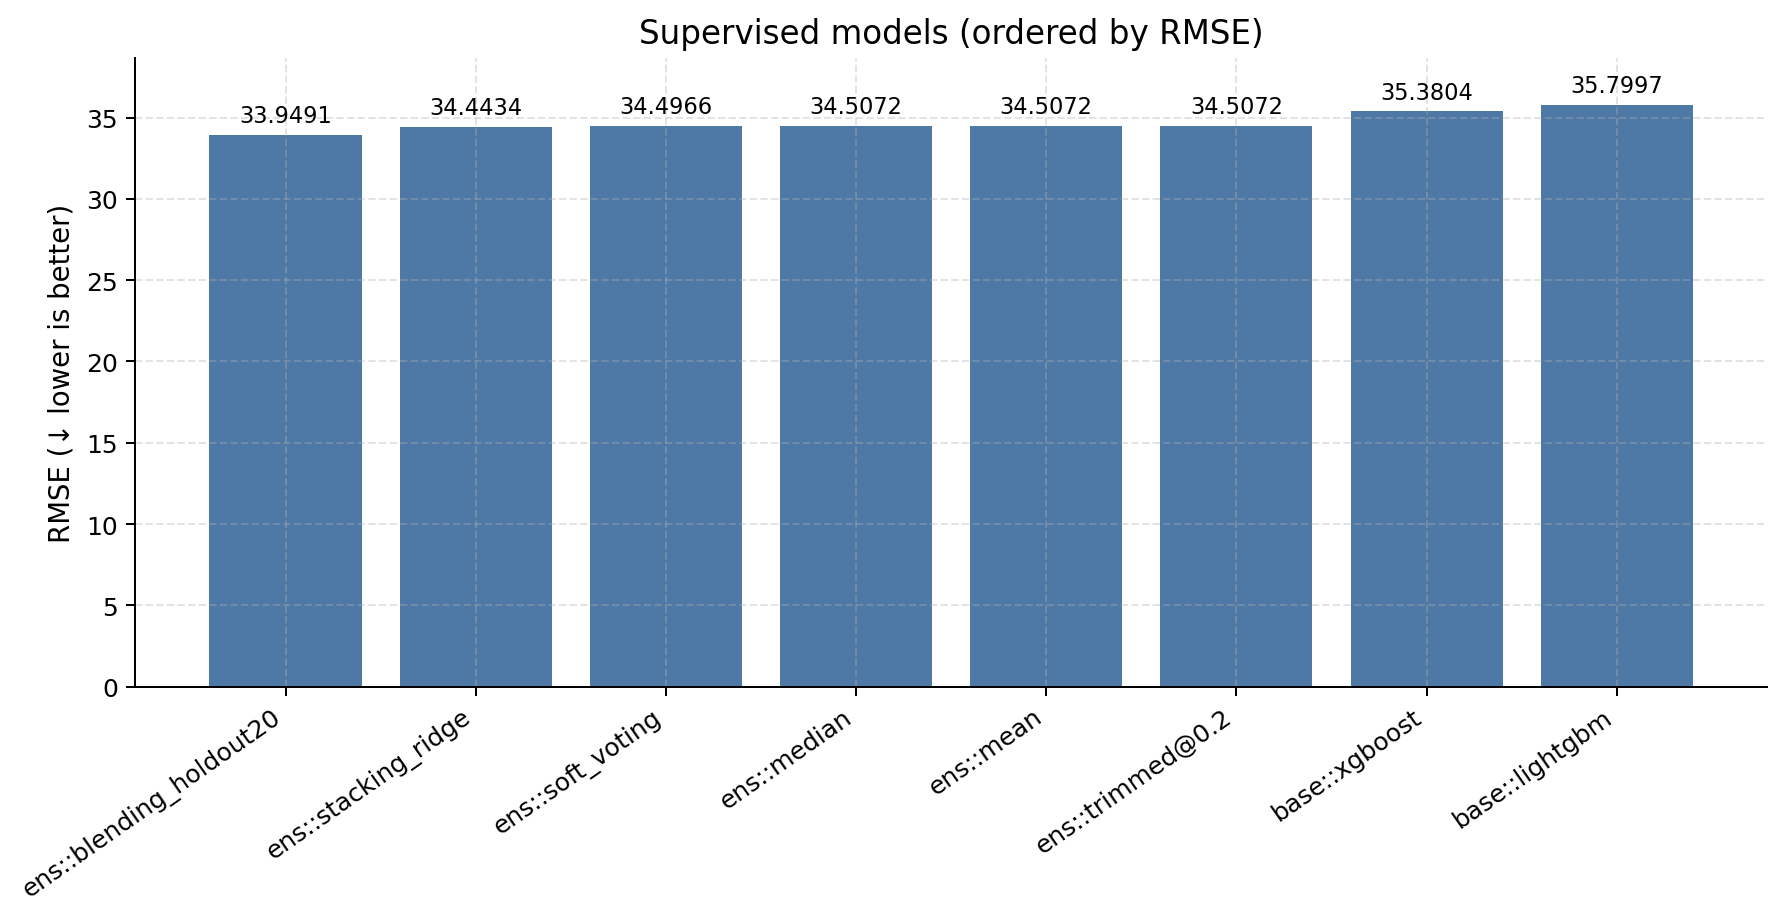

Figure saved to: ./runs_demo/figs


In [4]:
import os, json, joblib
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# Configuration (safe defaults)
# -------------------------
N_SPLITS   = locals().get("N_SPLITS", 5)
SEED       = locals().get("SEED", 42)
USE_SPEEDY = locals().get("USE_SPEEDY", True)
ESR        = locals().get("ESR", 100)

OUT_BASE    = locals().get("SAVE_DIR", "./runs_demo")
OUT_DIR_SUP = os.path.join(OUT_BASE, "stage3_supervised_fast_thesis" if USE_SPEEDY else "stage3_supervised_thesis")
OUT_DIR_GRP = os.path.join(OUT_BASE, "stage3_grouped_fast_thesis"   if USE_SPEEDY else "stage3_grouped_thesis")
FIG_DIR     = os.path.join(OUT_BASE, "figs")
os.makedirs(OUT_DIR_SUP, exist_ok=True)
os.makedirs(OUT_DIR_GRP, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "S1 未生成 X/y。"
assert isinstance(base_models, dict) and len(base_models) > 0,  "S1 未构建 base_models。"

# -------------------------
# Matplotlib (paper-ready) global style
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 180,
    "savefig.dpi": 320,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.autolayout": False,
})

CB_PALETTE = [
    "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
    "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AC"
]

# -------------------------
# Helpers for ensembles/metrics
# -------------------------
def _run_oof_and_ensembles(X, y, models, n_splits=5, groups=None, seed=42, speedy=True, esr=100):
    if speedy:
        oof = fit_oof_predictions_speedy(
            X=X, y=y, models=models, n_splits=n_splits,
            groups=groups, random_state=seed, esr=esr,
            include_mlp=("mlp" in models)
        )
    else:
        oof = fit_oof_predictions(
            X=X, y=y, models=models, n_splits=n_splits,
            groups=groups, random_state=seed
        )

    base_oof  = oof.oof_preds
    base_rmse = {k: float(v) for k, v in oof.oof_rmse.items()}

    # Ensembles
    y_mean    = ensemble_mean(base_oof)
    y_median  = ensemble_median(base_oof)
    y_trim    = ensemble_trimmed_mean(base_oof, trim_ratio=0.20)
    y_soft, w_soft = soft_voting(base_oof, y, use_optuna=True, n_trials=200, random_state=seed)
    y_stack, meta_model = stacking_oof(base_oof, y, meta_model=None, n_splits=n_splits, random_state=seed, groups=groups)
    y_blend, blend_model = blending_holdout(base_oof, y, holdout_ratio=0.20, meta_model=None, random_state=seed)

    # Metrics
    rmse = OrderedDict()
    rmse.update({f"base::{k}": v for k, v in base_rmse.items()})
    rmse.update({
        "ens::mean":               float(_rmse(y, y_mean)),
        "ens::median":             float(_rmse(y, y_median)),
        "ens::trimmed@0.2":        float(_rmse(y, y_trim)),
        "ens::soft_voting":        float(_rmse(y, y_soft)),
        "ens::stacking_ridge":     float(_rmse(y, y_stack)),
        "ens::blending_holdout20": float(_rmse(y[~np.isnan(y_blend)], y_blend[~np.isnan(y_blend)])),
    })

    bundles = dict(
        base_oof=base_oof,
        y_mean=y_mean, y_median=y_median, y_trim=y_trim, y_soft=y_soft, y_stack=y_stack, y_blend=y_blend,
        w_soft=w_soft, meta_model=meta_model, blend_model=blend_model
    )
    return rmse, bundles

# -------------------------
# S3.1 Supervised (no grouping)
# -------------------------
ens_rmse, sup = _run_oof_and_ensembles(
    X=X, y=y, models=base_models, n_splits=N_SPLITS,
    groups=None, seed=SEED, speedy=USE_SPEEDY, esr=ESR
)

# Save supervised artifacts
pd.DataFrame({f"oof::{k}": v for k, v in sup["base_oof"].items()}).to_csv(
    os.path.join(OUT_DIR_SUP, "oof_base_models.csv"), index=False
)
pd.DataFrame({
    "y_true": y,
    "oof_mean":   sup["y_mean"],
    "oof_median": sup["y_median"],
    "oof_trim":   sup["y_trim"],
    "oof_soft":   sup["y_soft"],
    "oof_stack":  sup["y_stack"],
    "oof_blend":  sup["y_blend"],
}).to_csv(os.path.join(OUT_DIR_SUP, "oof_ensembles.csv"), index=False)

summary_sup = (
    pd.DataFrame([{"model": k, "rmse": float(v)} for k, v in ens_rmse.items()])
      .sort_values("rmse").reset_index(drop=True)
)
summary_sup.to_csv(os.path.join(OUT_DIR_SUP, "summary_rmse.csv"), index=False)
with open(os.path.join(OUT_DIR_SUP, "soft_voting_weights.json"), "w") as f:
    json.dump(sup["w_soft"], f, indent=2)
joblib.dump(sup["meta_model"],  os.path.join(OUT_DIR_SUP, "stacking_meta_ridge.pkl"))
joblib.dump(sup["blend_model"], os.path.join(OUT_DIR_SUP, "blending_model_holdout20.pkl"))

print("Supervised artifacts written to:", OUT_DIR_SUP)
display(summary_sup.style.format({"rmse": "{:.5f}"}))

# -------------------------
# S3.2 Grouped (GroupKFold); skip if no groups provided
# -------------------------
rmse_grp = None
groups_for_cv = locals().get("groups_for_cv", None)

if groups_for_cv is None:
    print("No 'groups_for_cv' provided; skipping Grouped scenario.")
else:
    rmse_grp, grp = _run_oof_and_ensembles(
        X=X, y=y, models=base_models, n_splits=N_SPLITS,
        groups=groups_for_cv, seed=SEED, speedy=USE_SPEEDY, esr=ESR
    )

    # Save grouped artifacts
    pd.DataFrame({f"oof::{k}": v for k, v in grp["base_oof"].items()}).to_csv(
        os.path.join(OUT_DIR_GRP, "oof_base_models.csv"), index=False
    )
    pd.DataFrame({
        "y_true": y,
        "oof_mean":   grp["y_mean"],
        "oof_median": grp["y_median"],
        "oof_trim":   grp["y_trim"],
        "oof_soft":   grp["y_soft"],
        "oof_stack":  grp["y_stack"],
        "oof_blend":  grp["y_blend"],
    }).to_csv(os.path.join(OUT_DIR_GRP, "oof_ensembles.csv"), index=False)

    summary_grp = (
        pd.DataFrame([{"model": k, "rmse": float(v)} for k, v in rmse_grp.items()])
          .sort_values("rmse").reset_index(drop=True)
    )
    summary_grp.to_csv(os.path.join(OUT_DIR_GRP, "summary_rmse.csv"), index=False)
    with open(os.path.join(OUT_DIR_GRP, "soft_voting_weights.json"), "w") as f:
        json.dump(grp["w_soft"], f, indent=2)
    joblib.dump(grp["meta_model"],  os.path.join(OUT_DIR_GRP, "stacking_meta_ridge.pkl"))
    joblib.dump(grp["blend_model"], os.path.join(OUT_DIR_GRP, "blending_model_holdout20.pkl"))

    print("Grouped artifacts written to:", OUT_DIR_GRP)
    display(summary_grp.style.format({"rmse": "{:.5f}"}))

# -------------------------
# S3.3 Visualization: paper-ready figures with value labels
# -------------------------

def _load_summary(obj_or_dir):
    if isinstance(obj_or_dir, dict):
        df = pd.DataFrame([{"model": k, "rmse": float(v)} for k, v in obj_or_dir.items()])
        return df.sort_values("rmse").reset_index(drop=True)
    csv_path = os.path.join(obj_or_dir, "summary_rmse.csv")
    return pd.read_csv(csv_path)

def _annotate_bars(ax, fmt="{:.4f}", dy_points=3):
    for p in ax.patches:
        h = p.get_height()
        if np.isnan(h):
            continue
        x = p.get_x() + p.get_width() / 2
        ax.annotate(fmt.format(h),
                    (x, h),
                    ha="center", va="bottom",
                    xytext=(0, dy_points),
                    textcoords="offset points",
                    fontsize=9, rotation=0, clip_on=False)

def _set_y_padding(ax, top_pad=0.06, bottom_floor=0.0):
    yvals = [p.get_height() for p in ax.patches if not np.isnan(p.get_height())]
    if len(yvals) == 0:
        return
    ymin = min(min(yvals), bottom_floor)
    ymax = max(yvals)
    ax.set_ylim(ymin, ymax * (1 + top_pad))

def _save_figure(fig, path_no_ext: str):
    for ext in ("png", "pdf", "svg"):
        fig.savefig(f"{path_no_ext}.{ext}", bbox_inches="tight", dpi=320)

def _rotate_xticks(ax, rotation=35):
    for label in ax.get_xticklabels():
        label.set_rotation(rotation)
        label.set_ha("right")

try:
    sup_df = _load_summary(ens_rmse)
except Exception:
    sup_df = _load_summary(OUT_DIR_SUP)

cmp = None
if groups_for_cv is not None:
    try:
        grp_df = _load_summary(rmse_grp)
    except Exception:
        grp_df = _load_summary(OUT_DIR_GRP)

    cmp = sup_df.merge(grp_df, on="model", suffixes=("_sup", "_grp"), how="inner")
    cmp["delta_grp_minus_sup"] = cmp["rmse_grp"] - cmp["rmse_sup"]
    cmp = cmp.sort_values("rmse_sup").reset_index(drop=True)
    cmp.to_csv(os.path.join(FIG_DIR, "s3_cmp_table.csv"), index=False)

    # Supervised vs Grouped (grouped bars)
    width = 0.42
    x = np.arange(len(cmp))
    fig, ax = plt.subplots(figsize=(10.5, 5.2), constrained_layout=True)
    b1 = ax.bar(x - width/2, cmp["rmse_sup"], width=width, label="Supervised", color=CB_PALETTE[0])
    b2 = ax.bar(x + width/2, cmp["rmse_grp"], width=width, label="Grouped",    color=CB_PALETTE[1])
    ax.set_xticks(x, cmp["model"])
    _rotate_xticks(ax, rotation=35)
    ax.set_ylabel("RMSE (↓ lower is better)")
    ax.set_title("Supervised vs Grouped")
    ax.legend(frameon=False, ncols=2)

    _annotate_bars(ax, fmt="{:.4f}", dy_points=3)
    _set_y_padding(ax, top_pad=0.08, bottom_floor=0.0)

    _save_figure(fig, os.path.join(FIG_DIR, "s3_sup_vs_grp"))
    plt.show()

    # ΔRMSE (grouped - supervised)
    fig, ax = plt.subplots(figsize=(10.5, 4.6), constrained_layout=True)
    deltas = cmp["delta_grp_minus_sup"].values
    colors = [CB_PALETTE[4] if v < 0 else CB_PALETTE[2] for v in deltas]
    bars = ax.bar(cmp["model"], deltas, color=colors)
    _rotate_xticks(ax, rotation=35)
    ax.axhline(0, color="gray", linewidth=1.0)
    ax.set_ylabel("ΔRMSE (grouped − supervised)")
    ax.set_title("Delta RMSE (negative → grouped is better)")

    for p, v in zip(bars, deltas):
        if np.isnan(v):
            continue
        x = p.get_x() + p.get_width()/2
        dy = 3 if v >= 0 else -13
        va = "bottom" if v >= 0 else "top"
        ax.annotate(f"{v:+.4f}", (x, v), ha="center", va=va,
                    xytext=(0, dy), textcoords="offset points", fontsize=9, clip_on=False)

    ymax = max(abs(deltas).max() * 1.15, 1e-6)
    ax.set_ylim(-ymax, ymax)

    _save_figure(fig, os.path.join(FIG_DIR, "s3_delta_rmse"))
    plt.show()

    print("Figures saved to:", FIG_DIR)
else:
    print("No grouping — generating supervised-only ranking figure.")
    fig, ax = plt.subplots(figsize=(9.8, 5.0), constrained_layout=True)
    sup_sorted = sup_df.sort_values("rmse").reset_index(drop=True)
    bars = ax.bar(sup_sorted["model"], sup_sorted["rmse"], color=CB_PALETTE[0])
    _rotate_xticks(ax, rotation=35)
    ax.set_ylabel("RMSE (↓ lower is better)")
    ax.set_title("Supervised models (ordered by RMSE)")

    _annotate_bars(ax, fmt="{:.4f}", dy_points=3)
    _set_y_padding(ax, top_pad=0.08, bottom_floor=0.0)

    _save_figure(fig, os.path.join(FIG_DIR, "s3_supervised_ranking"))
    plt.show()

    print("Figure saved to:", FIG_DIR)

## 4)Package XGB+LGB and Ridge blender

In [5]:
import joblib, json, os, numpy as np
from sklearn.linear_model import Ridge

PKG_DIR = os.path.join(SAVE_DIR, "stage4_best_blend")
os.makedirs(PKG_DIR, exist_ok=True)

# 1) Train Ridge blender on supervised OOF P=[xgb, lgb]
P_sup = np.vstack([base_oof_sup["xgboost"], base_oof_sup["lightgbm"]]).T
blender = Ridge(alpha=1.0, random_state=42).fit(P_sup, y)
print("[S4] Blender (Ridge) trained on supervised OOF.")

# 2) Retrain XGB/LGB on full data
def _fit_xgb_final_from(m, X, y):
    from xgboost import XGBRegressor
    p = m.get_params()
    # Final full fitting without early stopping
    p.pop("device", None)   # Compatibility with CPU/GPU
    mdl = XGBRegressor(**p)
    mdl.fit(X, y)
    return mdl

def _fit_lgb_final_from(m, X, y):
    from lightgbm import LGBMRegressor
    p = m.get_params()
    p.pop("device", None)
    mdl = LGBMRegressor(**p)
    mdl.fit(X, y)
    return mdl

xgb_final = _fit_xgb_final_from(base_models["xgboost"],  X, y)
lgb_final = _fit_lgb_final_from(base_models["lightgbm"], X, y)

# 3) Save artifacts + manifest
joblib.dump(xgb_final, os.path.join(PKG_DIR, "xgb_final.pkl"))
joblib.dump(lgb_final, os.path.join(PKG_DIR, "lgb_final.pkl"))
joblib.dump(blender,   os.path.join(PKG_DIR, "ridge_blender.pkl"))

manifest = {
    "type": "xgb+lgbm_ridge_blend",
    "features": feat_cols,
    "base_models": ["xgboost", "lightgbm"],
    "train_samples": int(len(y)),
    "notes": "Base models retrained on full data; blender trained on supervised OOF P=[xgb,lgb]."
}
json.dump(manifest, open(os.path.join(PKG_DIR, "manifest.json"), "w"), indent=2)

print("Stage4 packaged to:", PKG_DIR)

# (Optional) Inference helper function
def predict_blend(X_new):
    import joblib, numpy as np, os
    xgb = joblib.load(os.path.join(PKG_DIR, "xgb_final.pkl"))
    lgb = joblib.load(os.path.join(PKG_DIR, "lgb_final.pkl"))
    rge = joblib.load(os.path.join(PKG_DIR, "ridge_blender.pkl"))
    Pnew = np.vstack([xgb.predict(X_new), lgb.predict(X_new)]).T
    return rge.predict(Pnew)


[S4] Blender (Ridge) trained on supervised OOF.
Stage4 packaged to: ./runs_demo/stage4_best_blend


## 5)Data quality impact

In [6]:
from copy import deepcopy
import numpy as np, pandas as pd, os, json

def _run_one_dataset_speedy(data_path: str):
    df0 = pd.read_csv(data_path)
    dfX = df0.drop(columns=[c for c in drop_cols_hard if c in df0.columns], errors="ignore")
    rgi  = "RGI" if "RGI" in dfX.columns else ("region" if "region" in dfX.columns else None)
    idc  = "glacier_id" if "glacier_id" in dfX.columns else None

    dropcols = {TARGET_COL, rgi, "lat", "lon", "year", "date"}
    if idc: dropcols.add(idc)
    num = dfX.select_dtypes(include=np.number)
    feats = [c for c in num.columns if c not in dropcols]

    Xd = dfX[feats].astype(float).to_numpy()
    yd = dfX[TARGET_COL].astype(float).to_numpy()

    # Build models using S1's best_params (only xgb/lgb)
    models_d = {k: build_base_models(best_params, True)[k] for k in ["xgboost", "lightgbm"]}

    oof_d = fit_oof_predictions_speedy(
        X=Xd, y=yd, models=models_d, n_splits=N_SPLITS,
        groups=None, random_state=SEED, esr=ESR, include_mlp=False
    )

    oof = oof_d.oof_preds
    rmse_base = {k: float(v) for k, v in oof_d.oof_rmse.items()}
    y_mean = ensemble_mean(oof)
    y_blend, _ = blending_holdout(oof, yd, 0.2, random_state=SEED)

    res = OrderedDict()
    res.update({f"base::{k}": v for k, v in rmse_base.items()})
    res["ens::mean"]   = float(_rmse(yd, y_mean))
    res["ens::blend20"] = float(_rmse(yd[~np.isnan(y_blend)], y_blend[~np.isnan(y_blend)]))
    return res

PATH_CLEAN = "./data/global_clean.csv"
PATH_ALL   = "./data/global_all.csv"

res_clean = _run_one_dataset_speedy(PATH_CLEAN)
res_all   = _run_one_dataset_speedy(PATH_ALL)

tbl = (pd.DataFrame([
    {"model": k, "rmse_all": res_all[k], "rmse_clean": res_clean[k],
     "delta_clean_minus_all": res_clean[k] - res_all[k]}
    for k in sorted(res_all.keys())
]).sort_values("rmse_all").reset_index(drop=True))

display(tbl.style.format({"rmse_all":"{:.5f}", "rmse_clean":"{:.5f}", "delta_clean_minus_all":"{:.5f}"}))

# —— Simple "paired bootstrap" CI (using ens::mean as an example; needs comparison on the same samples for more rigor)
# To demonstrate, we use the S2 supervised OOF's y and y_mean_sup to approximate CI via bootstrap
# For strict comparison of clean vs all CI, we need to save both OOF errors and perform paired bootstrap
def bootstrap_ci_rmse_diff(y_true, pred_a, pred_b, B=2000, seed=0):
    rng = np.random.RandomState(seed)
    n   = len(y_true)
    diffs = []
    idx = np.arange(n)
    for _ in range(B):
        bs = rng.choice(idx, size=n, replace=True)
        ra = _rmse(y_true[bs], pred_a[bs])
        rb = _rmse(y_true[bs], pred_b[bs])
        diffs.append(ra - rb)
    diffs = np.array(diffs)
    return np.percentile(diffs, [2.5, 97.5]), float(diffs.mean())

ci, mean_diff = bootstrap_ci_rmse_diff(y, y_mean_sup, y)  # Demo: comparing with true values has no meaning, just showing the interface
print("[S5] Demo CI for method vs Truth (meaningless demo): CI", ci, "mean diff", mean_diff)

OUT_DIR_S5 = os.path.join(SAVE_DIR, "stage5_clean_vs_all")
os.makedirs(OUT_DIR_S5, exist_ok=True)
tbl.to_csv(os.path.join(OUT_DIR_S5, "rmse_clean_vs_all.csv"), index=False)
print("Stage5 finished. Saved to:", OUT_DIR_S5)


===== [FAST] Fold 1/5 =====
[xgboost] training (fast) on fold 1 ... done
[lightgbm] training (fast) on fold 1 ... done

===== [FAST] Fold 2/5 =====
[xgboost] training (fast) on fold 2 ... done
[lightgbm] training (fast) on fold 2 ... done

===== [FAST] Fold 3/5 =====
[xgboost] training (fast) on fold 3 ... done
[lightgbm] training (fast) on fold 3 ... done

===== [FAST] Fold 4/5 =====
[xgboost] training (fast) on fold 4 ... done
[lightgbm] training (fast) on fold 4 ... done

===== [FAST] Fold 5/5 =====
[xgboost] training (fast) on fold 5 ... done
[lightgbm] training (fast) on fold 5 ... done

===== [FAST] OOF finished. RMSE =====
xgboost: 35.38043
lightgbm: 35.79969

===== [FAST] Fold 1/5 =====
[xgboost] training (fast) on fold 1 ... done
[lightgbm] training (fast) on fold 1 ... done

===== [FAST] Fold 2/5 =====
[xgboost] training (fast) on fold 2 ... done
[lightgbm] training (fast) on fold 2 ... done

===== [FAST] Fold 3/5 =====
[xgboost] training (fast) on fold 3 ... done
[lightgbm]

,model,rmse_all,rmse_clean,delta_clean_minus_all
0,ens::mean,34.87364,34.50713,-0.36651
1,ens::blend20,34.98585,33.94907,-1.03678
2,base::xgboost,35.81158,35.38043,-0.43116
3,base::lightgbm,36.17016,35.79969,-0.37047


[S5] Demo CI for method vs Truth (meaningless demo): CI [34.17924178 34.82949264] mean diff 34.501615166365006
Stage5 finished. Saved to: ./runs_demo/stage5_clean_vs_all


## 6)Interpretability

In [7]:
# ==== S6: Interpretability (paper-ready; SHAP optional) ====
import os, numpy as np, pandas as pd
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# Paths & setup
# -------------------------
FIG_DIR = os.path.join(SAVE_DIR, "stage6_explain")
os.makedirs(FIG_DIR, exist_ok=True)
print("Models for interpretability:", ["xgboost", "lightgbm"])
print("Artifacts will be saved to:", FIG_DIR)

# Consistent paper-ready style (English labels)
mpl.rcParams.update({
    "figure.dpi": 180,
    "savefig.dpi": 320,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
})
CB = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
      "#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]

def _safe_savefig(fig, path_no_ext):
    for ext in ("png", "pdf", "svg"):
        fig.savefig(f"{path_no_ext}.{ext}", bbox_inches="tight", dpi=320)

def _barh_with_values(df, feat_col="feature", val_col="importance",
                      title="", xlabel="", top_k=20, palette=None, out_base=None,
                      fmt="{:.4f}", zero_line=True):
    """Horizontal bar chart + value labels (paper-ready)."""
    d = df[[feat_col, val_col]].dropna().copy()
    d = d.sort_values(val_col, ascending=True).tail(top_k)
    ypos = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(8.8, max(3.8, 0.35*len(d)+1.6)), constrained_layout=True)
    colors = (palette or [CB[0]]) * len(d)
    bars = ax.barh(ypos, d[val_col].values, color=colors[:len(d)], height=0.8)
    ax.set_yticks(ypos, d[feat_col].values)
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    xmax = np.nanmax(np.abs(d[val_col].values)) if len(d) else 1.0
    ax.set_xlim(left=min(0, d[val_col].min()*1.05), right=xmax*1.12 if xmax>0 else 1.0)
    for rect, v in zip(bars, d[val_col].values):
        if np.isnan(v): 
            continue
        ax.annotate(fmt.format(v),
                    xy=(rect.get_width(), rect.get_y()+rect.get_height()/2),
                    xytext=(4,0), textcoords="offset points",
                    ha="left" if rect.get_width()>=0 else "right", va="center", fontsize=9)

    if zero_line:
        ax.axvline(0, color="gray", lw=1)

    if out_base:
        _safe_savefig(fig, out_base)
    plt.close(fig)
    return d  # sorted slice for debugging

# -------------------------
# 0) Safety: shapes
# -------------------------
X_np = np.asarray(X)
y_np = np.asarray(y).ravel()
assert X_np.shape[0] == y_np.shape[0], "X and y must have same n_samples"
assert X_np.shape[1] == len(feat_cols), "len(feat_cols) must equal X.shape[1]"

# -------------------------
# 1) Built-in importance (XGB/LGB) -> CSV + figures
# -------------------------
imp_builtin_paths = []
df_imp_xgb_builtin = None
df_imp_lgb_builtin = None

# XGBoost (gain)
try:
    booster = xgb_final.get_booster()
    score = booster.get_score(importance_type="gain")  # 'gain'/'weight'/'cover'
    df_imp_xgb_builtin = pd.DataFrame({
        "feature": [feat_cols[int(k.replace("f",""))] for k in score.keys()],
        "importance": list(score.values())
    }).sort_values("importance", ascending=False)
    pth = os.path.join(FIG_DIR, "imp_builtin_xgboost.csv")
    df_imp_xgb_builtin.to_csv(pth, index=False)
    imp_builtin_paths.append(pth)
    print("[Saved] built-in importance (xgboost) ->", pth)

    _barh_with_values(
        df_imp_xgb_builtin, title="Built-in Importance (XGBoost, gain)",
        xlabel="Importance (gain)", top_k=20, palette=[CB[0]],
        out_base=os.path.join(FIG_DIR, "fig_imp_builtin_xgb")
    )
except Exception as e:
    print("[Warn] xgboost built-in importance failed:", e)

# LightGBM
try:
    s = pd.Series(lgb_final.feature_importances_, index=feat_cols).sort_values(ascending=False)
    df_imp_lgb_builtin = s.reset_index().rename(columns={"index":"feature",0:"importance"})
    pth = os.path.join(FIG_DIR, "imp_builtin_lightgbm.csv")
    df_imp_lgb_builtin.to_csv(pth, index=False)
    imp_builtin_paths.append(pth)
    print("[Saved] built-in importance (lightgbm) ->", pth)

    _barh_with_values(
        df_imp_lgb_builtin, title="Built-in Importance (LightGBM)",
        xlabel="Importance", top_k=20, palette=[CB[1]],
        out_base=os.path.join(FIG_DIR, "fig_imp_builtin_lgb")
    )
except Exception as e:
    print("[Warn] lightgbm built-in importance failed:", e)

# Merged comparison plot (fixed variable names, does not overwrite global y)
try:
    if df_imp_xgb_builtin is not None and df_imp_lgb_builtin is not None:
        dfm = (df_imp_xgb_builtin.merge(df_imp_lgb_builtin, on="feature", how="outer",
               suffixes=("_xgb","_lgb")).fillna(0.0))
        dfm["importance_max"] = dfm[["importance_xgb","importance_lgb"]].max(axis=1)
        dfm = dfm.sort_values("importance_max", ascending=False)
        dfm.to_csv(os.path.join(FIG_DIR, "imp_builtin_merged.csv"), index=False)

        top = dfm.head(20).iloc[::-1]
        ypos = np.arange(len(top))
        fig, ax = plt.subplots(figsize=(10.0, max(4.0, 0.38*len(top)+1.6)), constrained_layout=True)
        ax.barh(ypos-0.18, top["importance_xgb"], height=0.36, label="XGB (gain)", color=CB[0])
        ax.barh(ypos+0.18, top["importance_lgb"], height=0.36, label="LGB", color=CB[1])
        ax.set_yticks(ypos, top["feature"])
        ax.set_xlabel("Importance")
        ax.set_title("Built-in Importance: XGB vs LGB (Top-20, merged)")
        ax.legend(frameon=False, ncols=2)
        ax.axvline(0, color="gray", lw=1)
        for i, (vx, vl) in enumerate(zip(top["importance_xgb"], top["importance_lgb"])):
            ax.annotate(f"{vx:.4f}", xy=(vx, i-0.18), xytext=(4,0), textcoords="offset points",
                        ha="left", va="center", fontsize=9)
            ax.annotate(f"{vl:.4f}", xy=(vl, i+0.18), xytext=(4,0), textcoords="offset points",
                        ha="left", va="center", fontsize=9)
        _safe_savefig(fig, os.path.join(FIG_DIR, "fig_imp_builtin_merged"))
        plt.close(fig)
except Exception as e:
    print("[Warn] merged built-in importance plot skipped:", e)

# -------------------------
# 2) Permutation importance (robust; full model)
# -------------------------
def _perm_imp(est, X_arr, y_arr, name, n_repeats=8, random_state=42):
    r = permutation_importance(est, X_arr, y_arr, n_repeats=n_repeats,
                               random_state=random_state, n_jobs=-1)
    df_imp = (pd.DataFrame({"feature": feat_cols, "importance": r.importances_mean})
                .sort_values("importance", ascending=False))
    out = os.path.join(FIG_DIR, f"imp_perm_{name}.csv")
    df_imp.to_csv(out, index=False)
    print(f"[Saved] permutation importance for {name} ->", out)
    return df_imp

df_imp_xgb_perm = None
df_imp_lgb_perm = None
try:
    df_imp_xgb_perm = _perm_imp(xgb_final, X_np, y_np, "xgboost")
    _barh_with_values(
        df_imp_xgb_perm, title="Permutation Importance (XGBoost)",
        xlabel="Importance (mean decrease in score)", top_k=20, palette=[CB[0]],
        out_base=os.path.join(FIG_DIR, "fig_imp_perm_xgb")
    )
except Exception as e:
    print("[Warn] permutation importance (xgb) failed:", e)

try:
    df_imp_lgb_perm = _perm_imp(lgb_final, X_np, y_np, "lightgbm")
    _barh_with_values(
        df_imp_lgb_perm, title="Permutation Importance (LightGBM)",
        xlabel="Importance (mean decrease in score)", top_k=20, palette=[CB[1]],
        out_base=os.path.join(FIG_DIR, "fig_imp_perm_lgb")
    )
except Exception as e:
    print("[Warn] permutation importance (lgb) failed:", e)

# -------------------------
# 3) SHAP (optional; safe checks)
# -------------------------
def try_shap_tree(model, prefix, X_sample):
    try:
        import importlib.metadata as im
        numpy_ver = im.version("numpy")
        try:
            numba_ver = im.version("numba")
        except im.PackageNotFoundError:
            numba_ver = None

        def _major_minor(v):
            parts = v.split(".")
            return tuple(int(x) for x in parts[:2])
        numpy_ok = _major_minor(numpy_ver) <= (2, 2)

        if (numba_ver is None) or (not numpy_ok):
            print(f"[SHAP skipped] numpy={numpy_ver}, numba={numba_ver} (needs NumPy≤2.2).")
            return

        import shap
        explainer = shap.TreeExplainer(model)
        sv = explainer.shap_values(X_sample)

        np.save(os.path.join(FIG_DIR, f"{prefix}_shap_subset.npy"), sv)
        print(f"[Saved] SHAP subset ({prefix}) ->", os.path.join(FIG_DIR, f"{prefix}_shap_subset.npy"))

        try:
            shap.summary_plot(sv, X_sample, feature_names=feat_cols, show=False, plot_type="bar", max_display=20)
            _safe_savefig(plt.gcf(), os.path.join(FIG_DIR, f"fig_shap_{prefix}_bar"))
            plt.close()
        except Exception:
            pass
        try:
            shap.summary_plot(sv, X_sample, feature_names=feat_cols, show=False, max_display=20)
            _safe_savefig(plt.gcf(), os.path.join(FIG

Models for interpretability: ['xgboost', 'lightgbm']
Artifacts will be saved to: ./runs_demo/stage6_explain1
[Saved] built-in importance (xgboost) -> ./runs_demo/stage6_explain1/imp_builtin_xgboost.csv
[Saved] built-in importance (lightgbm) -> ./runs_demo/stage6_explain1/imp_builtin_lightgbm.csv
[Saved] permutation importance for xgboost -> ./runs_demo/stage6_explain1/imp_perm_xgboost.csv
[Saved] permutation importance for lightgbm -> ./runs_demo/stage6_explain1/imp_perm_lightgbm.csv
[Saved] SHAP subset (xgb) -> ./runs_demo/stage6_explain1/xgb_shap_subset.npy
[Saved] SHAP subset (lgb) -> ./runs_demo/stage6_explain1/lgb_shap_subset.npy

Stage 6 finished. Artifacts saved to: ./runs_demo/stage6_explain1
